In [164]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

### Voronoi with supply (pimary care providers)



In [165]:
insurance_df = pd.read_csv('./data/health_insurance_coverage_2021.csv')
pcp_facilities_df = pd.read_csv('./data/pcp_facilities_2021.csv')
nys_counties_gdf = gpd.read_file('./data/NYS_Civil_Boundaries_Counties.geojson')

In [166]:
from geopandas.tools import sjoin

# Filter nys_counties_gdf with the 32 counties
counties_to_keep = pcp_facilities_df['County'].unique()
filtered_nys_counties_gdf = nys_counties_gdf[nys_counties_gdf['NAME'].isin(counties_to_keep)]

# Convert the DataFrame into a GeoDataFrame
pcp_facilities_gdf = gpd.GeoDataFrame(pcp_facilities_df, geometry=gpd.points_from_xy(pcp_facilities_df.Longitude, pcp_facilities_df.Latitude))
pcp_facilities_gdf.crs = "EPSG:4326"

# Spatial join to find facilities within NYS county polygons
filtered_pcp_facilities_gdf = sjoin(pcp_facilities_gdf, filtered_nys_counties_gdf, how="inner", predicate='within')
points = np.array([[point.x, point.y] for point in filtered_pcp_facilities_gdf.geometry])

print(points.shape)
print(points)

(12985, 2)
[[-74.242121  40.509265]
 [-74.205508  40.512789]
 [-74.235428  40.514345]
 ...
 [-74.90922   44.937561]
 [-74.908904  44.937721]
 [-74.90011   44.943672]]


In [167]:
from scipy.spatial import Voronoi

vor = Voronoi(points)

def voronoi_polygons(vor):
    regions = [r for r in vor.regions if r and -1 not in r]
    polygons = []
    for region in regions:
        polygon = [vor.vertices[i] for i in region]
        polygons.append(Polygon(polygon))
    return polygons

vor_polygons = voronoi_polygons(vor)
vor_gdf = gpd.GeoDataFrame(geometry=vor_polygons)
vor_gdf.crs = "EPSG:4326"

clipped_vor_gdf = gpd.clip(vor_gdf, filtered_nys_counties_gdf)

In [168]:
# Spatial join filtered_pcp_facilities_gdf attributes to the clipped_vor_gdf
columns_to_keep = ['Latitude', 'Longitude', 'County', 'pcp_medicaid', 'pcp_commercial', 'geometry']
filtered_pcp_facilities_gdf = filtered_pcp_facilities_gdf[columns_to_keep]

# Perform the spatial join
joined_vor_gdf = sjoin(clipped_vor_gdf, filtered_pcp_facilities_gdf, how="left", predicate="intersects")
joined_vor_gdf = joined_vor_gdf.dropna(subset=['Latitude', 'Longitude', 'County', 'pcp_medicaid', 'pcp_commercial'], how='all')
joined_vor_gdf = joined_vor_gdf.reset_index(drop=True)
joined_vor_gdf = joined_vor_gdf.drop(columns=['index_right'])

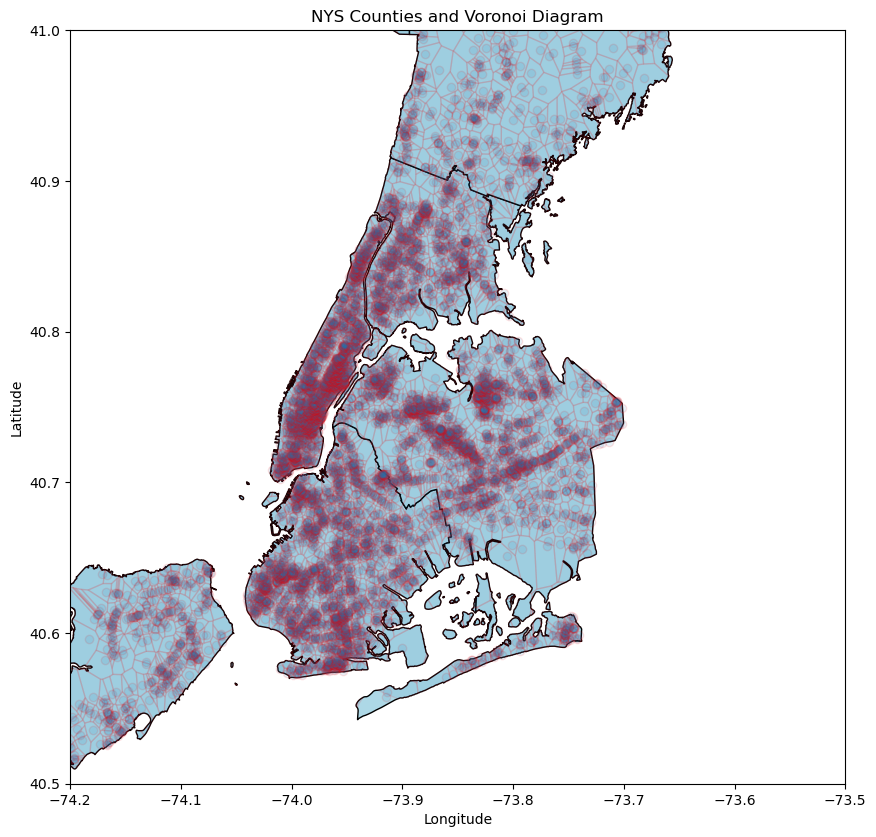

In [169]:
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
filtered_nys_counties_gdf.plot(ax=ax, color='lightblue', edgecolor='black')  # Plot NYS counties

# Assuming 'vor_gdf' is your GeoDataFrame of Voronoi polygons
joined_vor_gdf.plot(ax=ax, edgecolor='red', alpha=0.1)  # Plot Voronoi polygons on top
filtered_pcp_facilities_gdf.plot(ax=ax, edgecolor='red', alpha=0.1)

ax.set_xlim([-74.2, -73.5])
ax.set_ylim([40.5, 41])

plt.title('NYS Counties and Voronoi Diagram')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Voronoi with demand (population with commercial and medicaid plans)

In [170]:
# Load files to create polygons and Filter out polygons where 'AWATER' is larger than 'ALAND'
medicaid_tracts_gdf = gpd.read_file('./data/pcp_medicaid_tracts.geojson')
commercial_tract_gdf = gpd.read_file('./data/pcp_commercial_tracts.geojson')

In [171]:
medicaid_tracts_gdf = medicaid_tracts_gdf[["geometry", "medicaid"]]
commercial_tract_gdf = commercial_tract_gdf[["geometry", "commercial"]]
demand_tracts_gdf = medicaid_tracts_gdf
demand_tracts_gdf["commercial"] = commercial_tract_gdf["commercial"]
demand_tracts_gdf['tracts_id'] = demand_tracts_gdf.index
new_vor_gdf = joined_vor_gdf
new_vor_gdf['voronoi_cell_id'] = new_vor_gdf.index

# Matching CRS prior to spatial join
new_vor_gdf = new_vor_gdf.to_crs(demand_tracts_gdf.crs)
print(new_vor_gdf.crs)
print(demand_tracts_gdf.crs)

EPSG:32016
EPSG:32016


In [172]:
from geopandas import overlay

# Spatial join of demand_tracts_gdf data to the voronoi
# Calculate intersections and the area of each intersection
intersections = overlay(new_vor_gdf, demand_tracts_gdf, how='intersection')
intersections['intersection_area'] = intersections.geometry.area

# Calculate the total area of demand_tracts polygons that intersect with new_vor_gdf polygons
# This is necessary to calculate proportions correctly
total_area_per_demand_tract = intersections.dissolve(by='tracts_id', aggfunc='sum')['intersection_area']

# Merge this total area back onto the intersections dataframe
intersections = intersections.merge(total_area_per_demand_tract, on='tracts_id', suffixes=('', '_total'))

# Calculate the proportion of each demand tract's area that is within each voronoi cell
intersections['area_proportion'] = intersections['intersection_area'] / intersections['intersection_area_total']

# Use the proportion to distribute 'medicaid' and 'commercial' values
intersections['medicaid_distributed'] = intersections['medicaid'] * intersections['area_proportion']
intersections['commercial_distributed'] = intersections['commercial'] * intersections['area_proportion']

# Aggregate distributed values back to new_vor_gdf based on the voronoi cell's ID
aggregated_values = intersections.dissolve(by='voronoi_cell_id', aggfunc='sum')[['medicaid_distributed', 'commercial_distributed']]

# Merge these aggregated values back onto the original new_vor_gdf
new_vor_gdf = new_vor_gdf.merge(aggregated_values, on='voronoi_cell_id')

In [184]:
new_vor_gdf = new_vor_gdf[['geometry', 'Latitude', 'Longitude', 'County', 'pcp_medicaid', 'pcp_commercial', 'medicaid_distributed', 'commercial_distributed']]
new_vor_gdf['medicaid_distributed'] = new_vor_gdf['medicaid_distributed'].round(0)
new_vor_gdf['commercial_distributed'] = new_vor_gdf['commercial_distributed'].round(0)
new_vor_gdf['pcp_medicaid_per100'] = new_vor_gdf['pcp_medicaid'] / new_vor_gdf['medicaid_distributed'] * 100
new_vor_gdf['pcp_commercial_per100'] = new_vor_gdf['pcp_commercial'] / new_vor_gdf['commercial_distributed'] * 100
new_vor_gdf['disparity_index'] = new_vor_gdf['pcp_commercial_per100'] / new_vor_gdf['pcp_medicaid_per100']
new_vor_gdf['pcp_medicaid_per100'] = new_vor_gdf['pcp_medicaid_per100'].round(2)
new_vor_gdf['pcp_commercial_per100'] = new_vor_gdf['pcp_commercial_per100'].round(2)
new_vor_gdf['disparity_index'] = new_vor_gdf['disparity_index'].round(2)

In [185]:
new_vor_gdf.to_file('./healthcare_shortage_voronoi.geojson', driver='GeoJSON')
filtered_pcp_facilities_gdf.to_file('./pcp_facilities_32counties.geojson', driver='GeoJSON')